In [1]:
import pandas as pd
import numpy as np
import os
import time
import QuantLib as ql

In [2]:
fed_df = pd.read_csv('./_DATA/IR_FED_RES.csv')
fed_df['date'] = pd.to_datetime(fed_df['date'], format="%d/%m/%Y")
fed_df

FileNotFoundError: [Errno 2] No such file or directory: './_DATA/IR_FED_RES.csv'

In [ ]:
treasury_df = pd.read_csv('./_DATA/yield-curve-rates-1990-2023.csv')
treasury_df

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,12/29/23,5.60,5.59,5.40,5.41,5.26,4.79,4.23,4.01,3.84,3.88,3.88,4.20,4.03
1,12/28/23,5.57,5.55,5.45,5.42,5.28,4.82,4.26,4.02,3.83,3.84,3.84,4.14,3.98
2,12/27/23,5.55,5.53,5.44,5.42,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95
3,12/26/23,5.53,5.52,5.45,5.44,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
4,12/22/23,5.54,5.52,5.44,5.45,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8502,1/8/90,NaN,NaN,7.79,NaN,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
8503,1/5/90,NaN,NaN,7.79,NaN,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
8504,1/4/90,NaN,NaN,7.84,NaN,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
8505,1/3/90,NaN,NaN,7.89,NaN,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04


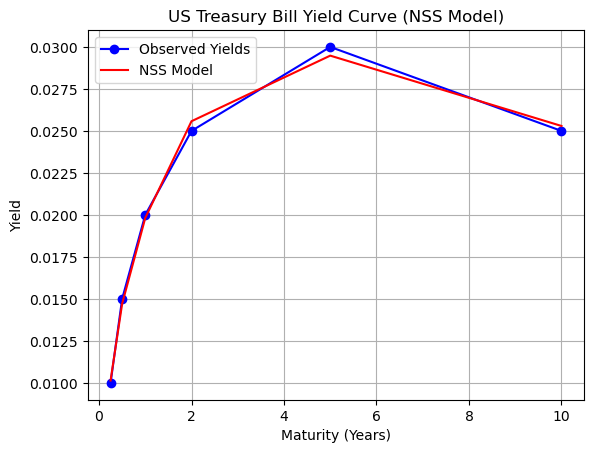

In [3]:
import numpy as np
from scipy.optimize import minimize

def nss_curve(params, maturities):
    b0, b1, b2, tau1, tau2 = params
    term1 = (1 - np.exp(-maturities / tau1)) / (maturities / tau1)
    term2 = ((1 - np.exp(-maturities / tau2)) / (maturities / tau2)) - np.exp(-maturities / tau2)
    yields = b0 + b1 * term1 + b2 * term2
    return yields

# Define the maturities and corresponding yields of US Treasury bills
maturities = np.array([0.25, 0.5, 1.0, 2.0, 5.0, 10.0])  # Maturities in years
yields = np.array([0.01, 0.015, 0.02, 0.025, 0.03, 0.025])  # Yields

# Define the objective function for optimization
def objective_function(params):
    predicted_yields = nss_curve(params, maturities)
    error = np.sum(np.square(predicted_yields - yields))
    return error

# Initial guess for the NSS model parameters
initial_params = [0.01, 0.01, 0.01, 1.0, 1.0]

# Perform optimization to fit the NSS model
result = minimize(objective_function, initial_params, method='Nelder-Mead')

# Extract the optimized NSS model parameters
optimized_params = result.x

# Generate yield curve using the optimized parameters
yield_curve = nss_curve(optimized_params, maturities)

# Plot the yield curve
import matplotlib.pyplot as plt
plt.plot(maturities, yields, marker='o', linestyle='-', color='blue', label='Observed Yields')
plt.plot(maturities, yield_curve, marker='', linestyle='-', color='red', label='NSS Model')
plt.title('US Treasury Bill Yield Curve (NSS Model)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

\begin{equation}
\text{Forward Rate} = \frac{yield_i maturity_i - yield_{i-1} maturity_{i-1}}{maturity_{i} - maturity_{i-1}}
\end{equation}
where e.g. $yield_{i}$ is the yield on 30 yr bonds and $yield_{i-1}$ is the yield on 20 yr bonds.

This would give the implied interest rate from 20 to 30 years ahead.

[ 0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.
  3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75  6.
  6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75  9.
  9.25  9.5   9.75 10.  ]


TypeError: 'numpy.ndarray' object is not callable

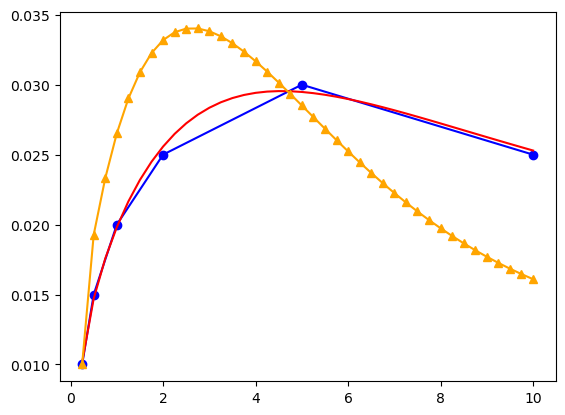

In [9]:
new_mat = np.arange(0.25, 10.25, 0.25)
print(new_mat)
# Generate yield curve using the optimized parameters
yield_curve = nss_curve(optimized_params, new_mat)


forward_rates = [yields[0]]
for i in range(1, len(new_mat)):
    forward_rate = (yield_curve[i] * new_mat[i] - yield_curve[i-1] * new_mat[i-1]) / (new_mat[i] - new_mat[i-1])
    forward_rates.append(forward_rate)

def continuous_forward_rate(yield_curve_func, t):
    
    current_yield = yield_curve_func(t)
    dydx = (yield_curve_func(t) - yield_curve_func(t-0.25))/(t - (t-0.25))

    return current_yield + dydx



plt.plot(maturities, yields, marker='o', linestyle='-', color='blue', label='Observed Yields')
plt.plot(new_mat, yield_curve, marker='', linestyle='-', color='red', label='NSS Model')
plt.plot(new_mat, forward_rates, marker='^', linestyle='-', color='orange', label='forward rate')
plt.plot(new_mat, continuous_forward_rate(nss_curve(optimized_params, new_mat), new_mat), marker='^', linestyle='-', color='green', label='continuous forward rate')
plt.title('US Treasury Bill Yield Curve (NSS Model)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forward rate